# **Automatic Hyperparameter Optimization with MMoCHi**

**Authors:** Daniel Caron and Will Specht

**In this notebook, we will use MMoCHi's built-in hyperparameter optimization to improve a classifier's performance for cell type annotation. This can be a helpful step if manual hyperparameter optimization fails, but is not memory- or time-optimized for very large datasets. If computational performance is an issue, you may consider randomly subsampling the dataset to test hyperparameters. This notebook will highlight some of the considerations taken during hyperparameter optimization and some keys to preventing overfitting.**

## **Import Packages**

In [2]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['legend.frameon'] = 'False'
plt.show() # so that the first plot will respect rcParams
import mmochi as mmc
import os
mmc.log_to_file('Hyperparameter_Optimization')

# Make the directory if not being run in the docs folder
if not os.path.isdir('data'):
    os.mkdir('data')

In [3]:
# Set deault locations in your anndata for MMoCHi to use for protein and batch labels
mmc.DATA_KEY = 'landmark_protein'
mmc.BATCH_KEY = 'batch'

In [4]:
# Load in your anndata
assert os.path.isfile('data/classified_events.h5ad'), 'Objects not found. Run the Integrated Clasification tutorial to generate them!'
adata = anndata.read_h5ad('data/classified_events.h5ad') 

### Create your hierarchy with hyperparameter optimization on

In [5]:
h= mmc.Hierarchy(default_min_events=15, default_class_weight = 'balanced',
                default_optimize_hyperparameters=True)

<div class="alert alert-warning">
    
**Note!** 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Optimization is performed using a pre-set list of hyperparameters and values, which can be altered using `hyperparameters`. The hyperparameters are optimized using a linear search (not a grid search) to save computational time. The order of this optimization is defined by `hyperparameter_order`. Optimization of a random forest is set internally to stop if subset balanced accuracy exceeds 98% or if there is less than a 0.4% improvement (e.g. with an increase in n_estimators). These defaults were included to save classification and optimization time and prevent overfitting, but can be adjusted using the `hyperparameter_optimization_cap` and `hyperparameter_min_improvement` respectively.

</div>

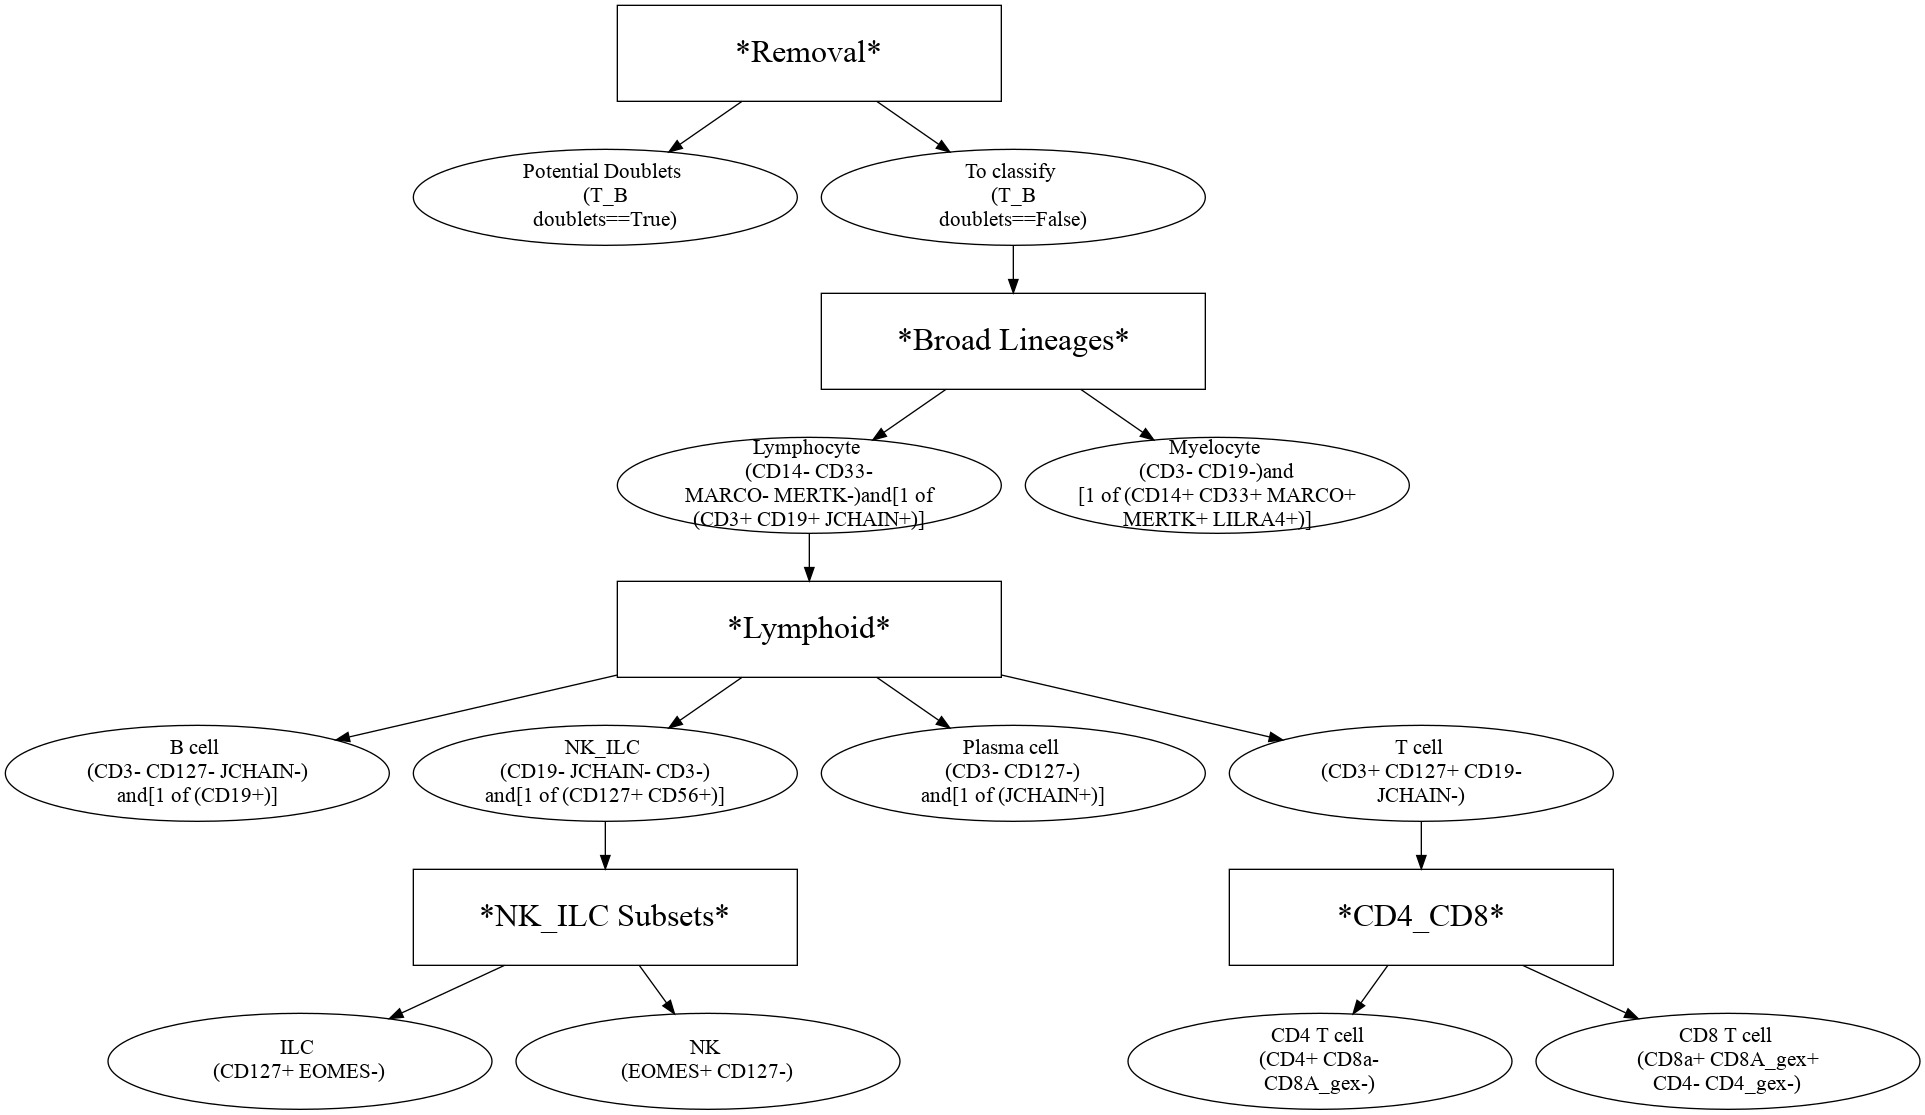

In [6]:
h.add_classification('Removal', 'All', ['T_B doublets'], is_cutoff=True) 
h.add_subset('Potential Doublets', 'Removal', ['True'])
h.add_subset('To classify', 'Removal', ['False'])
h.add_classification('Broad Lineages', 'To classify', ['CD14','CD33','MARCO','MERTK','CD3','CD19','JCHAIN','LILRA4']) 
h.add_subset('Lymphocyte', 'Broad Lineages', dict(neg=['CD14','CD33','MARCO','MERTK'], any_of=['CD3','CD19','JCHAIN'], n=1))
h.add_subset('Myelocyte', 'Broad Lineages', dict(any_of=['CD14','CD33','MARCO','MERTK','LILRA4'], neg=['CD3','CD19'], n=1))
h.add_classification('Lymphoid', 'Lymphocyte', ['CD3','CD19','CD56','CD127','JCHAIN'])           
h.add_subset('T cell', 'Lymphoid', dict(pos=['CD3','CD127'], neg=['CD19','JCHAIN']))
h.add_subset('B cell', 'Lymphoid', dict(any_of=['CD19'], neg=['CD3','CD127','JCHAIN']))
h.add_subset('Plasma cell', 'Lymphoid', dict(any_of=['JCHAIN'], neg=['CD3','CD127']))
h.add_subset('NK_ILC', 'Lymphoid', dict(neg=['CD19','JCHAIN','CD3'], any_of=['CD127','CD56']))
h.add_classification('NK_ILC Subsets', 'NK_ILC', ['CD127','EOMES'])
h.add_subset('NK', 'NK_ILC Subsets', dict(neg=['CD127',], pos=['EOMES',]))
h.add_subset('ILC', 'NK_ILC Subsets', dict(pos=['CD127',], neg=['EOMES',]))
h.add_classification('CD4_CD8', 'T cell', ['CD4','CD8a','CD4_gex','CD8A_gex'])
h.add_subset('CD4 T cell', 'CD4_CD8', dict(pos=['CD4',], neg=['CD8a','CD8A_gex']))
h.add_subset('CD8 T cell', 'CD4_CD8', dict(neg=['CD4','CD4_gex'], pos=['CD8a','CD8A_gex']))
h.display(True)

<div class="alert alert-info">

**Tip—Futher Optimization Specificity**
    
You can also optimize hyperparameters at a single level by passing 'optimize_hyperparameters=True' to that level or change the values checked using the default_hyperparameters argument and passing a dictionary with the values you would like to check.
</div>

In [7]:
h.reset_thresholds()
h.load_thresholds('data/integrated_thresholds.csv')

Loaded thresholds.


## **Time to run the classifier**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Optimization is as simple as running the classifier with optimization set to true. Keep an eye out for optimization print statements to better understand which layers are well fit.

In [8]:
adata, hierarchy = mmc.classify(adata, h.copy(), 'lin', 'landmark_protein', retrain=True, weight_integration=True)


Setting up...
Using .X and landmark_protein


Removing 18757 features lacking expression in a minimum of 25 events...
Resorting to enforce sorted order of features by name


Set up complete.
Using 14795 features


Running with batch batch
Using weights of: [0.4001677852348993, 0.5998322147651006] for random forest n_estimators


Data subsetted on All in All
Running high-confidence populations for Removal...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Performing cutoff for Removal...
Merging data into adata.obsm['lin']
Predicted:
Removal_class
To classify           13035
Potential Doublets       77
Name: count, dtype: int64
Data subsetted on To classify in Removal
Running high-confidence populations for Broad Lineages...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for Broad Lineages...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'Lymphocyte': 1.1632278397822295, 'Myelocyte': 1.9575665682936332}


Initializing classifier for Broad Lineages...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


3480 real cells in training set...


Resampling...


/home/ubuntu/miniconda3/envs/mmochi38/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/mmochi38/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/mmochi38/lib/python3.8/site-packages/

Training with 5024 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.3s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


4605 real cells in training set...


Resampling...


Found: 255 noise and 0 in danger of 4605 events.


Training with 6542 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s


Optimizing hyperparameters for Broad Lineages...
Best hyperparameters selected for level Broad Lineages as {'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0} with an balanced accuracy of 0.9829545454545455


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished


Merging data into adata.obsm['lin']
Running calibration on random forest


Calibrating with method isotonic


Predicting for Broad Lineages...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Predicted:
Broad Lineages_class
Lymphocyte    9163
Myelocyte     3872
Name: count, dtype: int64


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.5s finished


Data subsetted on Lymphocyte in Broad Lineages
Running high-confidence populations for Lymphoid...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for Lymphoid...


Checking subsets for minimum events...
Spiking in 14 of Plasma cell in 5k_pbmc_protein_v3 to reach 15 events
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'B cell': 3.144756783139567, 'NK_ILC': 2.4091166585409614, 'Plasma cell': 12.28905339451877, 'T cell': 1.178542915192636}


Initializing classifier for Lymphoid...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


2239 real cells in training set...


Resampling...


Found: 9 noise and 14 in danger of 2239 events.


Training with 7028 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.6s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


3541 real cells in training set...


Resampling...


Found: 10 noise and 8 in danger of 3541 events.


Training with 9708 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s


Optimizing hyperparameters for Lymphoid...
Checking hyperparameters n_estimators for values of [50, 100, 200, 400, 800, 1200]


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished


Score for n_estimators: 50 = 0.9710359857143637
Score for n_estimators: 100 = 0.9710359857143637
Best parameter for n_estimators was 50 with an accuracy score of 0.9710359857143637
Checking hyperparameters max_depth for values of [None, 10, 25]
Score for max_depth: None = 0.984308019024565
Score for max_depth: 10 = 0.9805201402366862
Score for max_depth: 25 = 0.9790943789035392
Best parameter for max_depth was None with an accuracy score of 0.984308019024565
Best hyperparameters selected for level Lymphoid as {'max_depth': None, 'n_estimators': 50, 'n_jobs': -1, 'bootstrap': True, 'verbose': True, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0} with an balanced accuracy of 0.984308019024565
Merging data into adata.obsm['lin']
Running calibration on random forest


Calibrating with method isotonic


Predicting for Lymphoid...
Merging data into adata.obsm['lin']
Predicted:
Lymphoid_class
T cell         6692
NK_ILC         1526
B cell          858
Plasma cell      87
Name: count, dtype: int64
Data subsetted on NK_ILC in Lymphoid
Running high-confidence populations for NK_ILC Subsets...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for NK_ILC Subsets...


Checking subsets for minimum events...
Spiking in 4 of ILC in 5k_pbmc_protein_v3 to reach 15 events
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'ILC': 2.6281947050033043, 'NK': 1.0813320474605401}


Initializing classifier for NK_ILC Subsets...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


88 real cells in training set...


Resampling...


Found: 4 noise and 3 in danger of 88 events.


Training with 154 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.1s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


209 real cells in training set...


Resampling...


Found: 1 noise and 8 in danger of 209 events.


Training with 384 events after oversample resampling...
Optimizing hyperparameters for NK_ILC Subsets...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished


Checking hyperparameters n_estimators for values of [50, 100, 200, 400, 800, 1200]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished


Score for n_estimators: 50 = 0.5
Score for n_estimators: 100 = 0.5833333333333334
Score for n_estimators: 200 = 0.6666666666666666
Score for n_estimators: 400 = 0.5
Best parameter for n_estimators was 200 with an accuracy score of 0.6666666666666666
Checking hyperparameters max_depth for values of [None, 10, 25]
Score for max_depth: None = 0.5
Score for max_depth: 10 = 0.5
Score for max_depth: 25 = 0.5
Best parameter for max_depth was None with an accuracy score of 0.5
Checking hyperparameters max_features for values of ['log2', 'sqrt', 0.01, 0.05, 0.1]
Score for max_features: log2 = 0.5
Score for max_features: sqrt = 0.5
Best parameter for max_features was log2 with an accuracy score of 0.5
Checking hyperparameters min_impurity_decrease for values of [0]
Score for min_impurity_decrease: 0 = 0.5
Best parameter for min_impurity_decrease was 0 with an accuracy score of 0.5
Checking hyperparameters bootstrap for values of [True, False]
Score for bootstrap: True = 0.5
Score for bootstrap: 

Calibration will not include separate _opt_holdout
Calibrating with method isotonic


Predicting for NK_ILC Subsets...
Merging data into adata.obsm['lin']
Predicted:
NK_ILC Subsets_class
NK     1236
ILC     290
Name: count, dtype: int64
Data subsetted on T cell in Lymphoid
Running high-confidence populations for CD4_CD8...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for CD4_CD8...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'CD4 T cell': 1.0944574683957464, 'CD8 T cell': 2.460622356116684}


Initializing classifier for CD4_CD8...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


2048 real cells in training set...


Resampling...


Found: 35 noise and 40 in danger of 2048 events.


Training with 3756 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.3s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


2502 real cells in training set...


Resampling...


Found: 22 noise and 17 in danger of 2502 events.


Training with 3926 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s


Optimizing hyperparameters for CD4_CD8...
Checking hyperparameters n_estimators for values of [50, 100, 200, 400, 800, 1200]


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished


Score for n_estimators: 50 = 0.9179104477611941
Score for n_estimators: 100 = 0.8805970149253732
Best parameter for n_estimators was 50 with an accuracy score of 0.9179104477611941
Checking hyperparameters max_depth for values of [None, 10, 25]
Score for max_depth: None = 0.9104477611940298
Score for max_depth: 10 = 0.9903051705756929
Score for max_depth: 25 = 0.7835820895522388
Best parameter for max_depth was 10 with an accuracy score of 0.9903051705756929
Best hyperparameters selected for level CD4_CD8 as {'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1, 'bootstrap': True, 'verbose': True, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0} with an balanced accuracy of 0.9903051705756929
Merging data into adata.obsm['lin']
Running calibration on random forest


Calibrating with method isotonic


Predicting for CD4_CD8...
Merging data into adata.obsm['lin']
Predicted:
CD4_CD8_class
CD4 T cell    5331
CD8 T cell    1361
Name: count, dtype: int64


Converting columns in adata.obsm["lin"] to savable dtypes...


In [9]:
adata = mmc.terminal_names(adata)

## **Evaluate your (potentially) improved performance**

First, let's check whether each layer is able to fit your data well

These confusion matrices measure how well fit your classier is at each level. If they are still poorly fit, consider redesign your hierarchy or improving your training data selection.

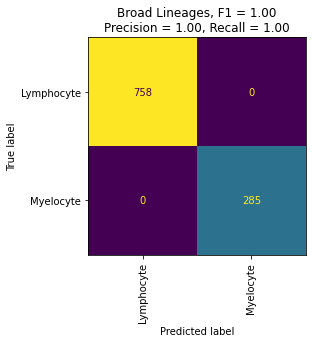

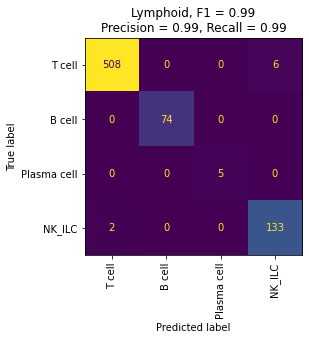

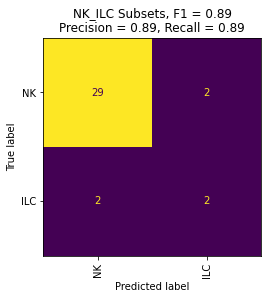

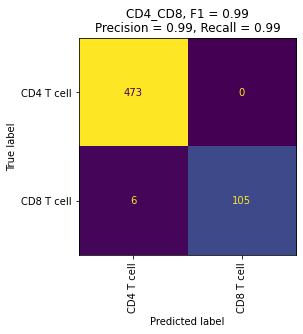

In [10]:
mmc.plot_confusion(adata, 'All', hierarchy, show=True, holdout_only=True, save='data/Confusion_plots.pdf')

#### Do classifications align with expected marker expression?
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The most important evaluation of classification performance is whether classified populations express expected marker genes and proteins. The MMoCHi classifications should reflect the known markers that were used in high-confidence thresholding, as well as other known cell type markers. We can inspect the classifications using the UMAP and markers from before:

In [11]:
protein_adata = anndata.AnnData(adata.obsm['landmark_protein'], adata.obs.copy(), dtype=float)
protein_adata.obsm['X_umap'] = adata.obsm['X_umap'].copy()

/home/ubuntu/miniconda3/envs/mmochi38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/mmochi38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


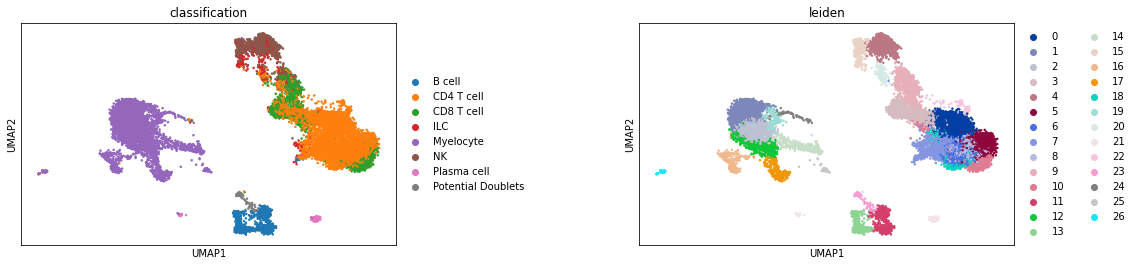

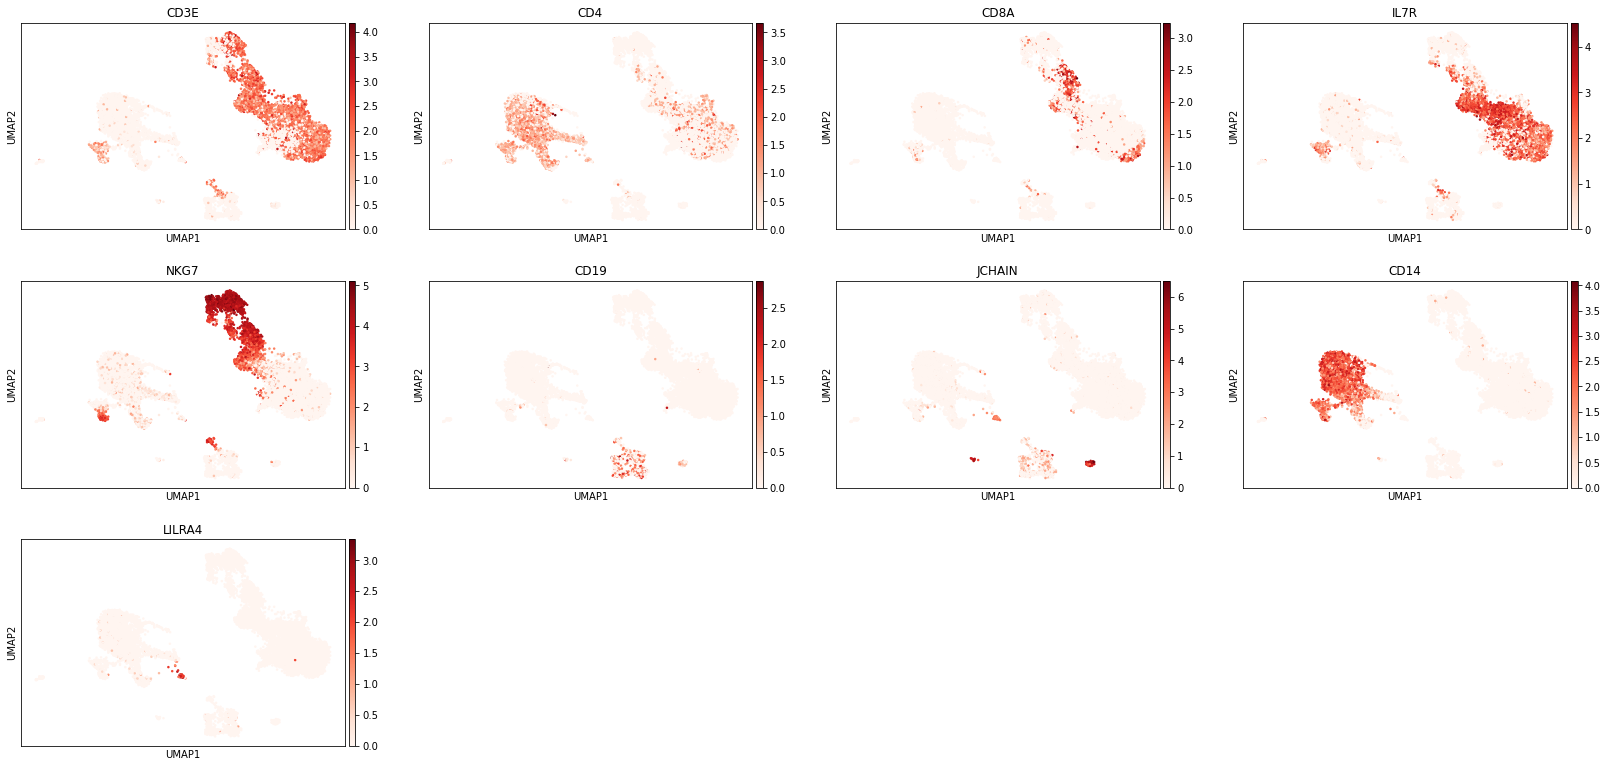

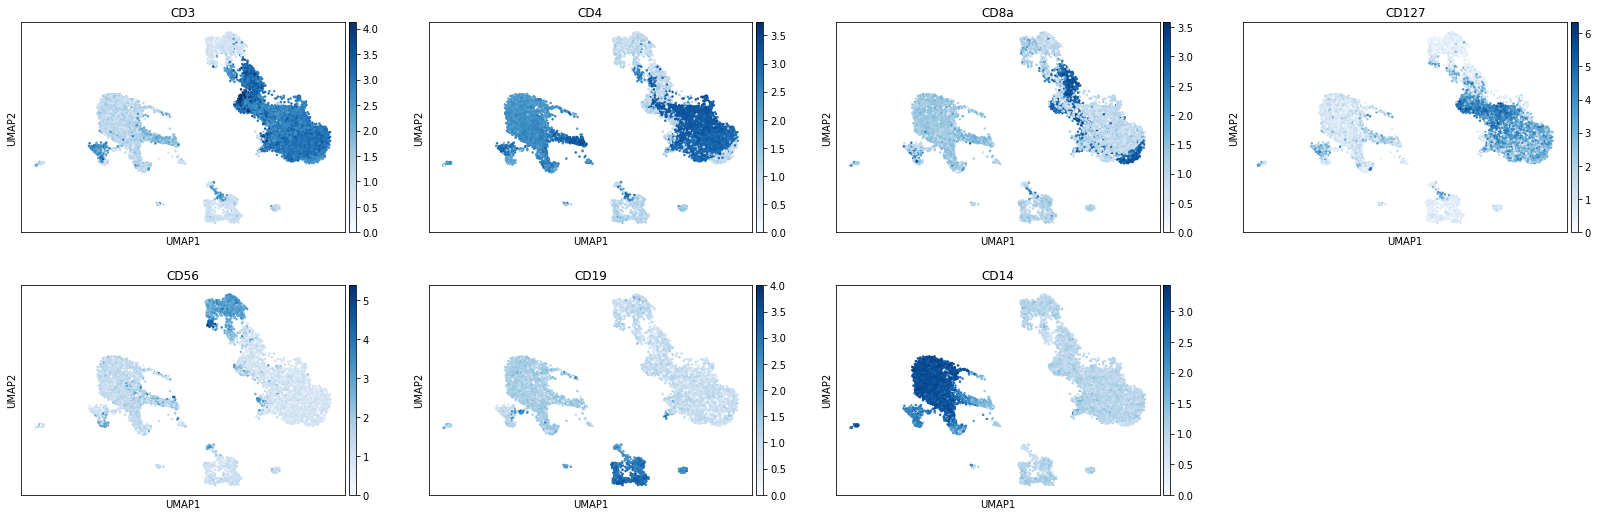

In [12]:
sc.pl.umap(adata, color=['classification','leiden'], s=25, sort_order=False, wspace=.5)
sc.pl.umap(adata, color=['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14','LILRA4'], s=25, sort_order=False, cmap='Reds')
sc.pl.umap(protein_adata, color=['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'], s=25, sort_order=False, cmap='Blues')

We can also look at marker expression using dotplots for GEX and violin plots for ADTs. This is great for populations that segregate poorly on the UMAP and can help to identify outliers.

/home/ubuntu/miniconda3/envs/mmochi38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


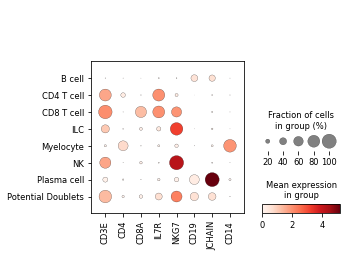

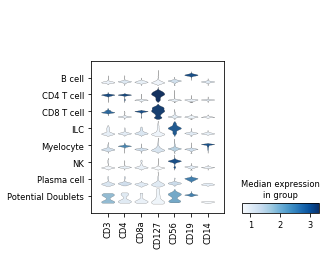

In [13]:
sc.pl.dotplot(adata, ['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'], 'classification')
protein_adata.obs['classification'] = adata.obs.classification
sc.pl.stacked_violin(protein_adata, ['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'], 'classification')

<div class="alert alert-info">

**Further Troubleshooting**
    
If classified subsets still do not align to known markers, you should check these other troubleshooting techniques:
1. High-confidence thresholding — Did you capture a relevant selection? See the [High-Confidence Thresholding tutorial](./High_Confidence_Thresholding.ipynb) for more details.
2. Training data cleanup and resampling — Are the high-confidence events well represented in training data? Alternative methods for cleanup and resampling are described in `mmc.classifier._balance_training_classes`. Note, alternative resampling methods are experimental.
3. Class imbalance — High imbalance between event numbers across subsets in one classification level may lead to poor classification performance, which is often revealed by sigmoidal-calibration plots. Consider altering classifier kwargs or redesigning the hierarchy to reduce/isolate this imbalance (imbalances tend to classify better in binary classification levels).
4. Learned representation — Are random forests learning the correct representation of the cell types? This question is explored in the [Exploring Feature Importances tutorial](./Exploring_Feature_Importances.ipynb), and these issues are best resolved by redesigning the hierarchy or changing feature inputs to isolate confounding variation. 
    
The plotting functions below can assist with identifying further issues in performance.
</div>

<div class="alert alert-success">

**Congratulations!** 
    
You've complete the automated hyperparameter optimization tutorial with MMoCHi!
</div>